# Face Recognition

## 1. Description

The dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel. 

## 2. Preparation

### 2.1 Setting up

In [1]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt
import time

Load the data:

In [2]:
data, labels = load_data()

### 2.2 Visualising the dataset

Display the faces by using the functions `show_single_face()` and `show_faces()`.

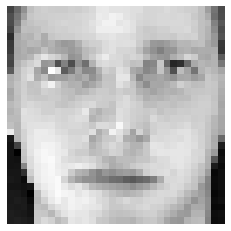

In [3]:
# Display a single example.
show_single_face(data[0, :])

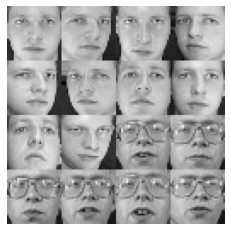

In [4]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### 2.3 Splitting into the train and test sets

Normalize your pixel values by 1/255 so that the feature values used in later experiments are between $[0,1]$. In general, the normalization trick can make it easier to tune parameters in machine learning experiments.

The data partition function is supplied to facilitate the experiments: it randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. The function takes the labels and the specified number $N$ as the input. And returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [5]:
# normalization
data = data / 255

# partition
# 30% training, 70% testing
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares
### 3.1 Implementation

`l2_rls_train` trains a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It supports both single-output and multi-output cases. This function takes a set of training samples and a user-specified regularisation parameter $\lambda$ (lambda) as the input, and returns the predicted weights. When $\lambda=0$, use a pseudo-inverse to implement the solution.

In [6]:
def l2_rls_train(data, labels, lmbd):
    """
    Train a linear model with L2-regularisation.

    data: array, shape (m samples, n features), the input training data
    labels: array with m labels, the true labels of the training data
    lmbd: float, the regularisation parameter

    Returns: array, the trained model weights
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    X_tilde = np.hstack((np.ones((X.shape[0], 1)), X))
    
    # Compute the coefficient vector.
    if lmbd == 0:
        # Use pseudo-inverse when lambda = 0
        w = np.linalg.pinv(X_tilde) @ y
    else:
        # Calculate the regularisation matrix
        reg = lmbd * np.eye(X_tilde.shape[1])
        w = np.linalg.inv(X_tilde.T @ X_tilde + reg) @ X_tilde.T @ y

    # Return model parameters.
    return w

# print(l2_rls_train(tr_data, tr_label, 1))

`l2_rls_predict` should take the trained weights and query data as the input, and return the corresponding prediction.

In [8]:
def l2_rls_predict(w, data):
    """
    Predict the label value using trained weights.

    w: array, trained weights
    data: array, shape (m samples, n features), the query data for prediction

    Returns: array with m predicted values
    """
    
    # Compute the prediction.
    # Expand X with a column of ones for bias term
    predicted_y = np.hstack((np.ones((data.shape[0], 1)), data)) @ w
    
    return predicted_y

# a = l2_rls_predict(l2_rls_train(tr_data, tr_label, 0), tr_data)
# print(a)

## 4. Face Recognition
### 4.1 Experiment

Perform multi-class classification to identify the subject in each image, for all 40 subjects.

Split the data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

In [39]:
# data already normalised

# partition
# 50% training, 50% testing
tr_ind, te_ind = partition_data(labels, num_per_class=5)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

# Note that you may find it helpful to use one-hot encoding to deal with multi-class labels

In [40]:
# one-hot encoding: each label is an array of length 40
# the position of 1 in the array shows which class it belongs to, values at other positions are 0s
# label 1: [1 0 0 ...], label 2: [0 1 0 ...], ... label 40: [0 0 ... 1]
def one_hot(label):
    label_matrix = np.eye(40)
    # index: 0-39
    encoded_label = label_matrix[label-1]
    # print(encoded_label.shape)
    return encoded_label

# one_hot(labels)

In [41]:
# predicted: each row has 40 values
def get_error_rate(predicted, true_label):
    # check element at which position is closest to 1
    # get the index: 0-39
    predict_class = np.argsort(1 - predicted, axis=1)[:, 0]  # ascending
    # get the index: 0-39, not the label(1-40)
    true_class = np.where(true_label == 1)[1]
    # print(np.where(true_label == 1))
    error_rate = np.mean(predict_class != true_class)
    error_std = np.std(predict_class != true_class)
    # print(true_class)
    return error_rate

# get_error_rate(pred, encoded_te_label)

In [42]:
from sklearn.model_selection import KFold
### Hyper-parameter selection and traing

# shuffle the dataset randomly
np.random.shuffle(tr_ind)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
encoded_tr_label = one_hot(tr_label)

# 5-fold CV, 200 data for training and validation
kf = KFold(n_splits=5)
error_rates = []
# test 28 lambdas
lambdas = [0] + [1*(10**x) for x in range(-5,0)] + [x for x in np.arange(0.25, 5, 0.25)] + [10**x for x in range(1,4)]
# [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 10, 100, 1000]

for lmbd in lambdas:
    err_rate_mean = []
    # 160 for training, 40 for validation
    for i, (train_index, validate_index) in enumerate(kf.split(tr_data, encoded_tr_label)):
        # use encoded labels
        w = l2_rls_train(tr_data[train_index], encoded_tr_label[train_index], lmbd)
        predicted = l2_rls_predict(w, tr_data[validate_index])
        true_label = encoded_tr_label[validate_index]
        
        error_rate = get_error_rate(predicted, true_label)
        err_rate_mean.append(error_rate)

    error_rates.append(np.mean(err_rate_mean))
    
min_error = min(error_rates)
best = error_rates.index(min_error)
print("Selected hyper parameter lambda: {}\nAccuracy: {}".format(lambdas[best], 1-min_error))

Selected hyper parameter lambda: 3.25
Accuracy: 0.88


In [54]:
### Retrain the model using the whole training dataset (200 data)
lmbd = lambdas[best]
w = l2_rls_train(tr_data, encoded_tr_label, lmbd)

### Evaluate using the test dataset (200 data)
pred = l2_rls_predict(w, te_data)
encoded_te_label = one_hot(te_label)
err_rate = get_error_rate(pred, encoded_te_label)
print("Accuracy of the test data: {}".format(1-err_rate))

# 40×40 classification error matrix (confusion matrix)
from sklearn import metrics
predict_class = np.argsort(1 - pred, axis=1)[:, 0]  # ascending
true_class = np.where(encoded_te_label == 1)[1]

print("40 x 40 classification error matrix for test:")
np.set_printoptions(threshold=np.inf,linewidth=100)
cm = metrics.confusion_matrix(true_class, predict_class)
print(cm)

Accuracy of the test data: 0.925
40 x 40 classification error matrix for test:
[[5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 

Some subjects that are considered the easist to recognise by the classifier:

Subjects that are considered the easist to recognise: 1 3 5 6


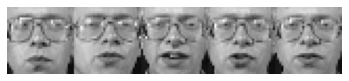

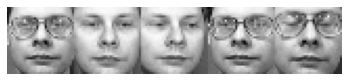

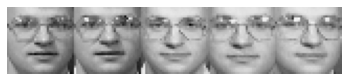

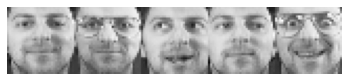

In [14]:
easy = np.where(cm.diagonal()==5)[0][:4]
print("Subjects that are considered the easist to recognise:", *easy)
for i in easy:
    show_faces(te_data[i*5:i*5+5, :], num_per_row=5)

Some subjects that are considered the most difficult to recognise by the classifier:

Subjects that are considered the most difficult to recognise: 18 7 0 30
Misclassified test images:


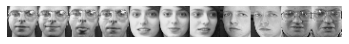

In [15]:
# select 3 subjects with lowest accuracy
difficult = np.argsort(cm.diagonal())[:4]
print("Subjects that are considered the most difficult to recognise:", *difficult)
# for i in difficult:
#     show_faces(te_data[i*5:i*5+5, :], num_per_row=5)
    
# misclassified test images
mis = []
for i in difficult:
    mis_ind = np.where(predict_class[i*5:i*5+5] != true_class[i*5:i*5+5])[0]
    mis += [i*5 + j for j in mis_ind]

print("Misclassified test images:")
show_faces(te_data[mis], num_per_row=len(mis))

## 5. Face Completion
Predict the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

In [16]:
left, right = split_left_right(data)

Visualise with the function `show_split_faces()`:

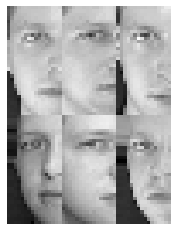

In [17]:
show_split_faces(left[:6, :], num_per_row=3)

### 5.1 Experiment

Build a face completion model using the regularised least squares model. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error (MAPE) to evaluate the regression performance. Simply set $\lambda$=0.

In [18]:
# 500 for training, 500 for testing
tr_ind, te_ind = partition_data(labels, num_per_class=5)
tr_data = left[tr_ind, :]
tr_out = right[tr_ind, :]
te_data = left[te_ind, :]
te_out = right[te_ind, :]

# training
w = l2_rls_train(tr_data, tr_out, lmbd=0)
right_pred = l2_rls_predict(w, te_data)

# testing: MAPE
mape = np.mean(np.abs((right_pred - te_out)/np.abs(te_out)))
print("Mean absolute percentage error:", mape)

Mean absolute percentage error: 0.229482100430039


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. Use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

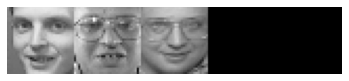

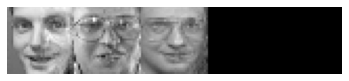

In [19]:
sample_ind = np.random.choice(200, 3, replace=False)
# true face
true_face = join_left_right(te_data[sample_ind, :], te_out[sample_ind, :])
show_faces(true_face, num_per_row=5)
# predict face
pred_face = join_left_right(te_data[sample_ind, :], right_pred[sample_ind, :])
show_faces(pred_face, num_per_row=5)

## 6. Training linear least squares model via gradient descent
Only consider **binary classification.** 
### 6.1 GD Implementation
`lls_gd_train` trains a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [20]:
def lls_gd_train(data, labels, N, learning_rate):
    """
    Train the single-output linear model with gradient descent using sum of squares loss function.

    data: array, shape(m samples, n fearures), the input training data
    labels: array with m labels, the true labels of the training data
    N: integer, iteration number
    learning_rate: float, rate for the update of the function

    Returns:
    cost_all: list, costs of the linear least squares in all iterations
    w_all: list, weights calculated in all iterations
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    X_tilde = np.hstack((np.ones((X.shape[0], 1)), X))
    
    # Weight initialization
    w = np.zeros(X_tilde.shape[1])

    # Initialise arrays to store weights and cost at each iteration
    w_all = []
    cost_all = []
    
    # GD update of weights
    for i in range(N):
        # cost and gradient descent of the linear least squares model
        gd = X_tilde.T @ X_tilde @ w - X_tilde.T @ y
        cost = 0.5 * np.sum(np.square(X_tilde @ w  - y))
        
        # Weight update
        w = w - learning_rate * gd
        
        # save w and cost of each iteration in w_all and cost_all
        w_all.append(w)
        cost_all.append(cost)
    
    # Return model parameters.
    return cost_all, w_all

### 6.2 Experiments

Apply this function to classify images from subject 1 and subject 30. Conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set the learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train the model. Plot in three figures (1) the change of the sum-of-squares error loss that it minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations.

In [21]:
def gd_analyse(N, learning_rate, draw=True):
    # partition
    # for subject 1 and 30: 3 for training, 7 for testing
    part_data = np.concatenate((data[:10], data[29*10:30*10]))
    part_labels = np.concatenate((labels[:10], labels[29*10:30*10]))
    tr_ind, te_ind = partition_data(part_labels, num_per_class=3)
    tr_data = part_data[tr_ind, :]
    tr_label = part_labels[tr_ind]
    te_data = part_data[te_ind, :]
    te_label = part_labels[te_ind]
    
    t = time.time()
    cost_all, w_all = lls_gd_train(tr_data, tr_label, N, learning_rate)
    excute_time = time.time() - t
    
    # train accuracy
    # w_all convert to: (1025, 200), 200 iterations
    w_all = np.array(w_all).T
    tr_pred = l2_rls_predict(w_all, tr_data)
    # tr_pred: (6, 200)
    tr_pred[tr_pred<=15.5] = 1
    tr_pred[tr_pred>15.5] = 30

    # broadcast to (6, 1) for comparison
    tr_label = tr_label[:, np.newaxis]
    tr_result = tr_pred == tr_label
    # calculate mean vertically (over iterations)
    tr_accuracy = np.mean(tr_result, axis=0)


    # test accuracy
    te_pred = l2_rls_predict(w_all, te_data)
    # te_pred: (14, 200)
    te_pred[te_pred<=15.5] = 1
    te_pred[te_pred>15.5] = 30

    # broadcast to (14, 1) for comparison
    te_label = te_label[:, np.newaxis]
    te_result = te_pred == te_label
    # calculate mean vertically (over iterations)
    te_accuracy = np.mean(te_result, axis=0)
    
    
    # plot
    if draw:
        plt.figure(figsize=(10, 4))
        plt.xlabel("iteration", size=12)
        plt.ylabel("sum-of-squares error loss", size=12)
        plt.title("Change of the sum-of-squares error loss (GD, N={}, rate={})".format(N, learning_rate), size=14)
        plt.plot(cost_all)
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.xlabel("iteration", size=12)
        plt.ylabel("train accuracy", size=12)
        plt.title("Change of accuracy for training samples (GD, N={}, rate={})".format(N, learning_rate), size=14)
        plt.plot(tr_accuracy)
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.xlabel("iteration", size=12)
        plt.ylabel("test accuracy", size=12)
        plt.title("Change of accuracy for test samples (GD, N={}, rate={})".format(N, learning_rate), size=14)
        plt.plot(te_accuracy)
        plt.show()

    return cost_all, tr_accuracy, te_accuracy, excute_time

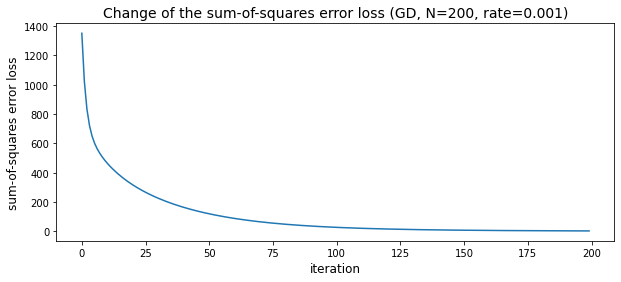

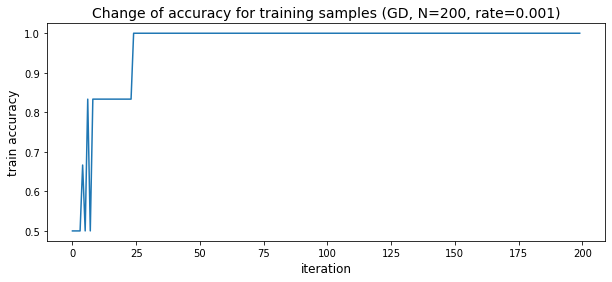

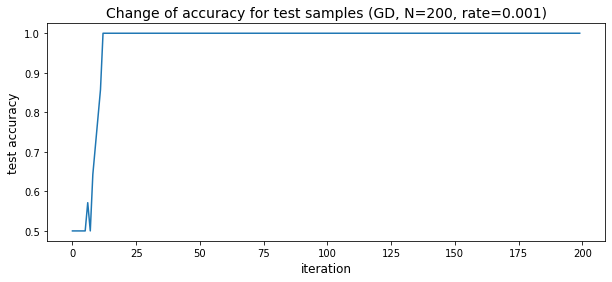

In [22]:
gd_analyse(200, 1e-3);

Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations.

C:\Users\12927\AppData\Local\Temp\ipykernel_31940\1938826004.py:32: RuntimeWarning: overflow encountered in square
  cost = 0.5 * np.sum(np.square(X_tilde @ w  - y))


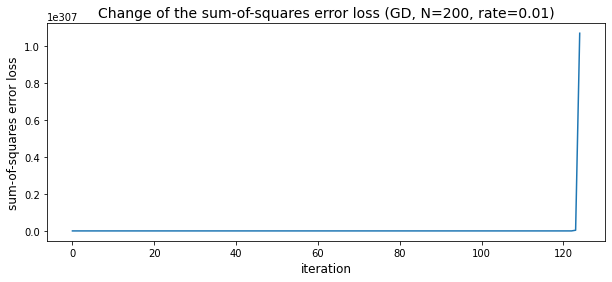

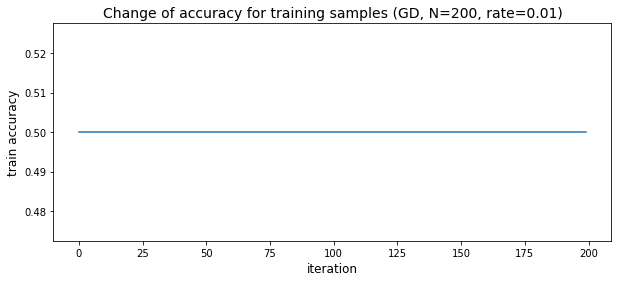

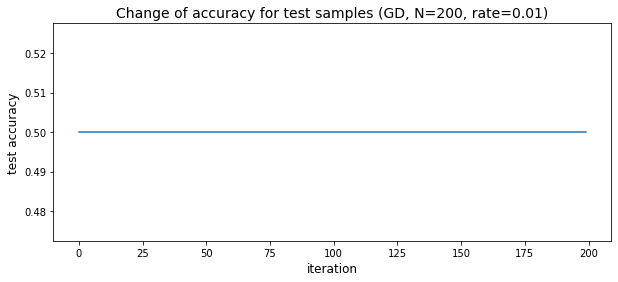

In [23]:
gd_analyse(200, 1e-2);

## 7. Advanced Gradient-based Training

### Method 1: Compare with stochastic gradient descent training
### 7.1 SGD Implementation 
Replace the gradient descent approach in Section 4 with a stochastic gradient descent approach: `lls_sgd_train`.

In [24]:
def lls_sgd_train(data, labels, N, learning_rate):
    """
    Train the single-output linear model with stochastic gradient descent using sum of squares loss function.

    data: array, shape(m samples, n fearures), the input training data
    labels: array with m labels, the true labels of the training data
    N: integer, iteration number
    learning_rate: float, rate for the update of the function

    Returns:
    cost_all: list, costs of the linear least squares in all iterations
    w_all: list, weights calculated in all iterations
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    X_tilde = np.hstack((np.ones((X.shape[0], 1)), X))
    
    # Weight initialization
    w = np.zeros(X_tilde.shape[1])

    # Initialise arrays to store weights and cost at each iteration
    w_all = []
    cost_all = []
    
    # GD update of weights
    for i in range(N):
        # randomly select a smaple
        ind = np.random.randint(0, X_tilde.shape[0])
        _x = X_tilde[ind][np.newaxis, :]
        _y = np.array([y[ind]])
        
        # cost and gradient descent of the linear least squares model
        sgd = _x.T @ _x @ w - _x.T @ _y
        cost = 0.5 * np.sum(np.square(_x @ w  - _y))
        
        # Weight update
        w = w - learning_rate * sgd
        
        # save w and cost of each iteration in w_all and cost_all
        w_all.append(w)
        cost_all.append(cost)
    
    # Return model parameters.
    return cost_all, w_all

### Method 2: Gradient descent training using hinge loss
For a single output model, the hinge loss over N training samples is $$O(\theta) = \sum^N_{i=1}\max\left(0, 1 - y_i f(\theta, x_i)\right)$$ where $y_i \in \{-1, +1\}$ is the class target label and $f(\theta, x_i)$ is your prediction function. While this is not directly differentiable, we can split it into two separately differentiable parts. For one sample, the above formuation is equivalent to:
$$
\max\left(0, 1 - y_i f(\theta, x_i)\right) = \begin{cases}
    0 & \text{if } y_i f(\theta, x_i) \geq 1 \\ % & is your "\tab"-like command (it's a tab alignment character)
    1-y_i f(\theta, x_i) & \text{otherwise.}
\end{cases}
$$

### 7.1 Implementation
Apply the gradient descent approach to train the classifier but by minimising the hinge loss.

`hinge_gd_train` trains a single-output linear model by minimising the hinge loss using the gradient descent approach. The optimisation function  includes a regularisation term and regularisation hyperparameter $C$. It takes the iteration number $N$, the learning rate $\eta$, and regularisation hyperparameter $C$ as arguments. To keep things simple, fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of the regularised hinge loss model calculated in all the iterations.

In [25]:
def hinge_gd_train(data, labels, N, learning_rate, C
          ):
    """
    Train a linear model by minimizing the hinge loss using gradient descent with regularisation.

    data: array, shape(m samples, n fearures), the input training data
    labels: array with m labels, the true labels of the training data
    N: integer, iteration number
    learning_rate: float, rate for the update of the function
    C: float, regularisation hyperparameter

    Returns: 
    cost_all: list, costs of the linear least squares in all iterations
    w_all: list, weights calculated in all iterations
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    X_tilde = np.hstack((np.ones((X.shape[0], 1)), X))
    
    # Weight initialization
    w = np.zeros(X_tilde.shape[1])

    # Initialise arrays to store weights and cost at each iteration
    w_all = []
    cost_all = []
        
    # GD update of weights
    for i in range(N):
        # cost and gradient descent of the linear hinge loss model
        product = y * (X_tilde @ w)

        # if product<1, use -y, else use 0 for gradient calculation
        _y = np.where(product<1, -y, 0)
        
        # gradient descent and cost with regularisation term
        hinge_gd = C * X_tilde.T @ _y + w
        cost = C * np.sum(np.maximum(0, 1-product)) + 0.5 * np.dot(w, w)
        
        # Weight update
        w = w - learning_rate * hinge_gd
        
        # save w and cost of each iteration in w_all and cost_all
        w_all.append(w)
        cost_all.append(cost)

    # Return model parameters.
    return cost_all, w_all


### 7.2 Experiment design
Design and implement an appropriate experiment to demonstrate the performance and behaviour difference for gradient descent training based on the least squared loss and the hinge loss. 


In [26]:
def hinge_analyse(N, learning_rate, draw=True):
    part_data = np.concatenate((data[:10], data[29*10:30*10]))
    part_labels = np.concatenate((labels[:10], labels[29*10:30*10]))
    tr_ind, te_ind = partition_data(part_labels, num_per_class=3)
    tr_data = part_data[tr_ind, :]
    tr_label = part_labels[tr_ind]
    te_data = part_data[te_ind, :]
    te_label = part_labels[te_ind]

    # label 1: -1, label 30: 1
    tr_label = tr_label.astype("int")
    te_label = te_label.astype("int")
    tr_label[tr_label==1] = -1
    tr_label[tr_label==30] = 1
    te_label[te_label==1] = -1
    te_label[te_label==30] = 1

    t = time.time()
    cost_all, w_all = hinge_gd_train(tr_data, tr_label, N, learning_rate, 1)
    excute_time = time.time() - t

    # train accuracy
    # w_all convert to: (1025, 200), 200 iterations
    w_all = np.array(w_all).T
    tr_pred = l2_rls_predict(w_all, tr_data)
    # tr_pred: (6, 200)
    tr_pred[tr_pred<=0] = -1
    tr_pred[tr_pred>0] = 1

    # broadcast to (6, 1) for comparison
    tr_label = tr_label[:, np.newaxis]
    tr_result = tr_pred == tr_label
    # calculate mean vertically (over iterations)
    tr_accuracy = np.mean(tr_result, axis=0)


    # test accuracy
    te_pred = l2_rls_predict(w_all, te_data)
    # te_pred: (14, 200)
    te_pred[te_pred<=0] = -1
    te_pred[te_pred>0] = 1

    # broadcast to (14, 1) for comparison
    te_label = te_label[:, np.newaxis]
    te_result = te_pred == te_label
    # calculate mean vertically (over iterations)
    te_accuracy = np.mean(te_result, axis=0)


    # plot
    if draw:
        plt.figure(figsize=(10, 4))
        plt.xlabel("iteration", size=12)
        plt.ylabel("sum-of-squares error loss", size=12)
        plt.title("Change of the sum-of-squares error loss (N={}, rate={})".format(N, learning_rate), size=14)
        plt.plot(cost_all)
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.xlabel("iteration", size=12)
        plt.ylabel("train accuracy", size=12)
        plt.title("Change of accuracy for training samples (N={}, rate={})".format(N, learning_rate), size=14)
        plt.plot(tr_accuracy)
        plt.show()

        plt.figure(figsize=(10, 4))
        plt.xlabel("iteration", size=12)
        plt.ylabel("test accuracy", size=12)
        plt.title("Change of accuracy for test samples (N={}, rate={})".format(N, learning_rate), size=14)
        plt.plot(te_accuracy)
        plt.show()
        
    return cost_all, tr_accuracy, te_accuracy, excute_time

# hinge_analyse(200, 0.001);

In [27]:
# difference between the least squared loss and the hinge loss
def compare_performance(N, learning_rate):
    cost_ls, tr_ls, te_ls, time_ls = gd_analyse(N, learning_rate, False)
    cost_h, tr_h, te_h, time_h = hinge_analyse(N, learning_rate, False)

    print("Least squares loss: {}s".format(time_ls))
    print("Hinge loss: {}s".format(time_h))   
    
    fig, axs = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)
    fig.suptitle("Least squares loss (N={}, learning rate={})".format(N, learning_rate), fontsize=18)

    axs[0].set_xlabel("iteration", size=12)
    axs[0].set_ylabel("sum-of-squares error loss", size=12)
    axs[0].set_title("Change of error loss", size=14)
    axs[0].plot(cost_ls)

    axs[1].set_xlabel("iteration", size=12)
    axs[1].set_ylabel("train accuracy", size=12)
    axs[1].set_title("Change of training accuracy", size=14)
    axs[1].plot(tr_ls)

    axs[2].set_xlabel("iteration", size=12)
    axs[2].set_ylabel("test accuracy", size=12)
    axs[2].set_title("Change of testing accuracy", size=14)
    axs[2].plot(te_ls)
    plt.show()

    fig, axs = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)
    fig.suptitle("Hinge loss (N={}, learning rate={})".format(N, learning_rate), fontsize=18)

    axs[0].set_xlabel("iteration", size=12)
    axs[0].set_ylabel("hinge error loss", size=12)
    axs[0].set_title("Change of error loss", size=14)
    axs[0].plot(cost_h)

    axs[1].set_xlabel("iteration", size=12)
    axs[1].set_ylabel("train accuracy", size=12)
    axs[1].set_title("Change of trainging accuracy", size=14)
    axs[1].plot(tr_h)

    axs[2].set_xlabel("iteration", size=12)
    axs[2].set_ylabel("test accuracy", size=12)
    axs[2].set_title("Change of testing accuracy", size=14)
    axs[2].plot(te_h)
    plt.show()

Least squares loss: 1.271942377090454s
Hinge loss: 0.009759902954101562s


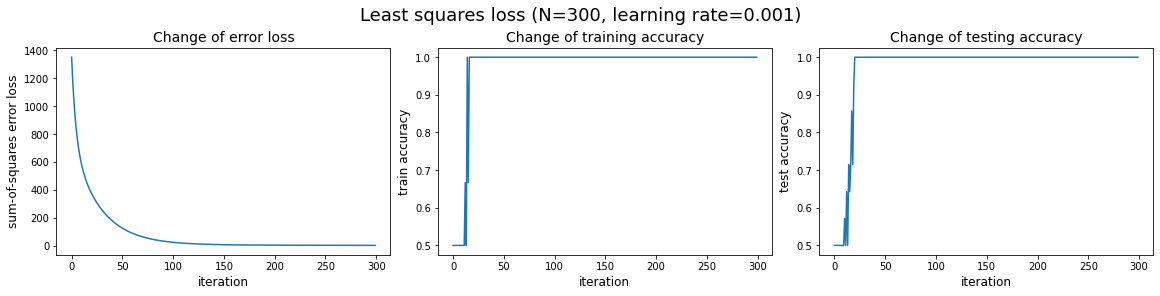

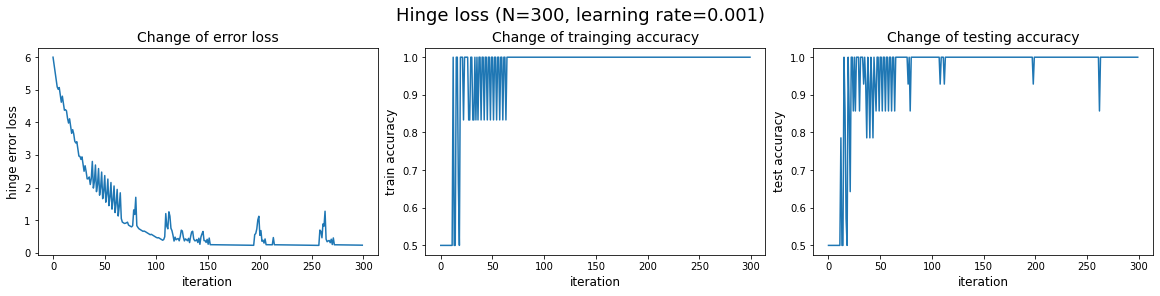

In [28]:
compare_performance(300, 0.001)

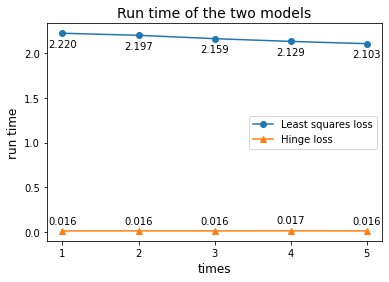

In [29]:
# compare run time
excution_time_ls = []
excution_time_h = []
for i in range(5):
    time_ls = gd_analyse(500, 0.001, False)[3]
    time_h = hinge_analyse(500, 0.001, False)[3]
    excution_time_ls.append(time_ls)
    excution_time_h.append(time_h)

plt.xlabel("times", size=12)
plt.ylabel("run time", size=12)
X = np.linspace(1,5,5)
plt.xticks([1, 2, 3, 4, 5])
plt.title("Run time of the two models", size=14)
plt.plot(X, excution_time_ls, marker="o", label="Least squares loss")
plt.plot(X, excution_time_h, marker="^", label="Hinge loss")
for i in range(5):
    plt.text(i+1, excution_time_ls[i]-0.15, "%.3f" % excution_time_ls[i], ha="center")
    plt.text(i+1, excution_time_h[i]+0.08, "%.3f" % excution_time_h[i], ha="center")
plt.legend()
plt.show()